
#  オペレーティングシステム 演習 10
#  キャッシュ

名前と学生証番号を書け. Enter your name and student ID.

 * 名前 Name:
 * 学生証番号 Student ID:

# 1. はじめに
* OSは一度読んだファイルはメモリ上に保持する<font color="blue">(キャッシュ)</font>
* ファイル読み込み時にすでにキャッシュされていれば, ディスクからの読み出し(IO)は行われず, 読み出しが高速に行われる
* キャッシュは物理メモリを消費するので, メモリ管理の節で述べたのと似た仕組み(LRUの近似)で管理される
* つまりしばらく使われなかったファイルがキャッシュから追い出される
* キャッシュにどれくらいのメモリが使われているかはこれまでも紹介したfree, vmstat, (端末上では) topなどで知ることができる


In [1]:
free

               total        used        free      shared  buff/cache   available
Mem:        32506280     9624364    17929144     2095904     7531848    22881916
Swap:        8388604           0     8388604


In [2]:
vmstat

procs -----------memory---------- ---swap-- -----io---- -system-- -------cpu-------
 r  b   swpd   free   buff  cache   si   so    bi    bo   in   cs us sy id wa st gu
 4  0      0 17936160 429032 7103316    0    0  1869   645 4246    9  6  2 92  0  0  0


* 以下ではファイルキャッシュの効果を体感する

# 2. 準備: 適当な大きさのファイルを作る
* 適当なサイズで, 中身がランダムなファイルを作るPythonプログラム

In [3]:
#!/usr/bin/python3
import os
import numpy as np

def mk_random_file(filename, size):
    assert(size <= 1000 * 1024 * 1024), "don't make it > 1GB"
    rg = np.random.RandomState()
    rg.seed(1234)
    a = rg.randint(0, 256, size=size, dtype=np.uint8)
    with open(filename, "wb") as wp:
        a.tofile(wp)


In [4]:
mk_random_file("data.bin", 500 * 1000 * 1000)

In [5]:
ls -l 

total 488332
-rw-r--r-- 1 tau tau 500000000 Dec 10 22:30 data.bin
-rw-r--r-- 1 tau tau     38189 Dec  4 01:01 os10_cache.sos.ipynb
-rw-r--r-- 1 tau tau      2630 Dec  4 01:01 read_file_vis.py


#  参考
* プログラムを書かずにコマンドを駆使するなら以下 (ddコマンドは知っておくと良いので参考までに紹介)
* ifは入力, ofは出力, bsは一度に読み書きする量, countはその回数なので以下は/dev/urandomというファイルから1000000 バイト読み出してdata.binに書く, を500回繰り返す

In [6]:
# 参考: 実行する必要なし

## dd if=/dev/urandom of=data.bin bs=$((1000 * 1000)) count=500

* `/dev/urandom`は読み出すたびに乱数を返す擬似ファイルなので, 上記は乱数でファイルを作ることになる
* 実際は中身は何でも良い(ゼロでも良い)のだが, ゼロでは中身が正しく読めていることのチェックにならないので乱数で埋めておく
* `/dev/urandom`の読み出しには無駄に時間がかかるし, 作るたびに異なるファイルできてしまうので, 以下のように自分でプログラムを書いてしまうほうが便利で速い

# 3. ファイルをキャッシュから追い出すには?
* キャッシュの効果を図るために, ファイルがキャッシュされた状態とそうでない状態を比べたいのだが, そうでない状態を作るのにトリックがいる
* ファイルは作った直後もキャッシュされているので上記を実行した直後はおそらくキャッシュされている
* ファイルをキャッシュから追い出すためにはいくつかの方法がある
  1. <font color="blue">たくさんのプロセスメモリを消費して, 追い出す.</font> 例えば32GBのメモリを持つマシンなら32GBのメモリを割り当て, 実際にアクセスして物理メモリを32GB使うプロセスを走らせれば, おそらくキャッシュは全て追い出される. しかしこれは一時的にメモリ不足を引き起こし, 最悪の場合はスラッシングを引き起こす. やるなら自分専用の仮想マシンにしておくべきだろう
  1. もう少し穏当には, <font color="blue">たくさんのキャッシュメモリを消費して追い出す.</font> 例えば32GBのメモリを持つマシンなら32GB以上のファイルを作ってそれを何度か読み出す. 果たして本当に追い出されるかは多少疑ったほうが良い(通常は古いものが追い出されるが, 小さいファイルや最近書き込まれたファイルのキャッシュを救って, 32GBの大きなファイルの一部を追い出すという判断がありえないわけではない). スラッシングなどの心配はないが, 32GBをディスクから読み出すのは時間がかかるし, これを何十人もの人が同時にやったら結構大変なことになる. 大きなメモリを持つマシンでこんなことを実験のためにやりたくはない
  1. 管理者権限があればできる裏技. 以下はOSに直接, <font color="blue">キャッシュを開放するよう指示するコマンド</font>
```
sudo sysctl -w vm.drop_caches=3
```
管理者権限が必要である
  1. <font color="blue">ユーザでも出来る上, 特定ファイルのキャッシュだけを開放できる裏技. `posix_fadvise`というシステムコール</font>でファイルへこれからどういうアクセスをするかのヒントを与えることが出来るがそのうちの, <font color="blue">`POSIX_FADV_DONTNEED`</font>というヒントを与えると, 指定した領域は当分不要とみなされ, キャッシュが開放される <font color="green">以下ではこれを使う</font>

In [7]:
%%writefile drop_cache.c
#include <assert.h>
#include <err.h>
#include <fcntl.h>
#include <stdio.h>
#include <stdlib.h>
#include <sys/mman.h>
#include <sys/stat.h>
#include <sys/types.h>
#include <unistd.h>

int drop_cache(const char * filename) {
  /* ファイルを開く */
  int fd = open(filename, O_RDWR, 0777);
  if (fd == -1) err(1, "open");
  struct stat sb[1];
  if (fstat(fd, sb) == -1) err(1, "fstat");
  if (fdatasync(fd) == -1) err(1, "fdatasync");
  long sz = sb->st_size;
  if (posix_fadvise(fd, 0, sz, POSIX_FADV_DONTNEED) == -1) {
    err(1, "posix_fadvise");
  }
  if (close(fd) == -1) err(1, "close");
  return 1;                     /* OK */
}

int main(int argc, char ** argv) {
  for (int i = 1; i < argc; i++) {
    drop_cache(argv[i]);
  }
  return 0;
}

Writing drop_cache.c


In [8]:
gcc -Wall -O3 -o drop_cache drop_cache.c

* 以下で, 上で作った5つのファルをキャッシュから追い出せる

In [9]:
./drop_cache data.bin

# 4. キャッシュをざっくり体感する
* キャッシュされた状態とそうでない状態を比べたければ同じファイルを2度アクセスしてみれば良い

* 1回目

In [10]:
time cat data.bin > /dev/null


real	0m1.128s
user	0m0.000s
sys	0m0.155s


* 2回目

In [11]:
time cat data.bin > /dev/null


real	0m0.049s
user	0m0.001s
sys	0m0.048s


* キャッシュは偉大で, 普段コンピュータがキビキビと動いている理由の一部は, よく使うもの(プログラムのコード, ライブラリなどを含め, 編集中のファイル, 何度も閉じたり開いたりしているファイルなど)がキャッシュ上に載っているからである
* コンピュータを立ち上げた直後プログラムの立ち上げが遅いが, 2度目は速くなるということを感じたことがないだろうか? 今度意識してみてください

# 5. (参考) ファイルがキャッシュにあるかどうかを知る
* ファイルがキャッシュにあるかどうかを知るのに fincore というコマンドがある

In [12]:
fincore data.bin

Command 'fincore' not found, but can be installed with:
sudo apt install util-linux-extra


: 127

* 以下で追い出してまたチェックしてみよ

In [13]:
./drop_cache data.bin

In [14]:
fincore data.bin

Command 'fincore' not found, but can be installed with:
sudo apt install util-linux-extra


: 127

In [15]:
# 再び読み出してみる
time cat data.bin > /dev/null


real	0m1.129s
user	0m0.002s
sys	0m0.159s


* システムコールとしては実は, mincore を使ってる. ファイルをmmapしておいてその領域が物理メモリにあるか否かをmincoreで調べれば, 「物理メモリ上にある = キャッシュ上にある」という関係になっている

* 以下は参考まで(fincoreの中身相当)

In [16]:
%%writefile check_incore.c
#include <assert.h>
#include <err.h>
#include <fcntl.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <sys/mman.h>
#include <sys/stat.h>
#include <sys/types.h>
#include <unistd.h>

int check_incore(char * filename) {
  /* ファイルを開く */
  int fd = open(filename, O_RDONLY);
  if (fd == -1) err(1, "open");
  /* ファイルのサイズ */
  struct stat sb[1];
  if (fstat(fd, sb) == -1) err(1, "fstat");
  /* mmap (読み出しのみ) */
  long sz = sb->st_size;
  char * a = mmap(0, sz, PROT_READ, MAP_SHARED, fd, 0);
  if (a == MAP_FAILED) err(1, "mmap");
  const long page_sz = 4096;
  long n_pages = (sz + page_sz - 1) / page_sz;
  unsigned char * incore = malloc(n_pages);
  memset(incore, 2, n_pages);

  if (mincore(a, n_pages * page_sz, incore) == -1) {
    err(1, "mincore");
  }
  long bytes_incore = 0;
  for (long i = 0; i < n_pages; i++) {
    assert(incore[i] == 0 || incore[i] == 1);
    if (incore[i]) bytes_incore += page_sz;
  }
  printf("%s : %ld bytes of %ld bytes on memory\n", filename, bytes_incore, sz);
  if (munmap(a, sz) == -1) err(1, "mumap");
  if (close(fd) == -1) err(1, "close");
  return 1;                     /* OK */
}

int main(int argc, char ** argv) {
  for (int i = 1; i < argc; i++) {
    check_incore(argv[i]);
  }
  return 0;
}

Writing check_incore.c


In [17]:
gcc -Wall -O3 -o check_incore check_incore.c

* 参考までに実行(fincoreと同じ)

In [18]:
./check_incore data.bin

data.bin : 500002816 bytes of 500000000 bytes on memory


In [19]:
./drop_cache data.bin

In [20]:
./check_incore data.bin

data.bin : 0 bytes of 500000000 bytes on memory


In [21]:
time cat data.bin > /dev/null


real	0m1.144s
user	0m0.001s
sys	0m0.159s


# 6. キャッシュの効果を測定する
* キャッシュの効果をきちんと測定してみよう
* 以下は
```
./read_file F S R B > s.dat
```
で <font color="blue">ファイルF の先頭 S [MB] をR回読む. 但し一回の読み出し(read)で B [バイト]ずつ読み出す</font>
* 読み出しごとに時刻を見て read に入った時点と readからリターンした時点を記録し, 標準出力に出す

In [22]:
%%writefile read_file.c
#define _GNU_SOURCE             /* See feature_test_macros(7) */
#include <assert.h>
#include <err.h>
#include <fcntl.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <sys/time.h>
#include <unistd.h>

/* イベントの種類 */
typedef enum {
  ek_read_enter,
  ek_read_return,
} event_kind_t;

/* 1イベントの記録 */
typedef struct {
  double t;                     /* 時刻 */
  event_kind_t kind;            /* イベントの種類(read呼び出し, read復帰, etc.) */
  size_t offset;                /* 読んだ場所 */
  size_t size;                  /* 読んだサイズ */
} record_t;

/* 全イベントの記録 */
typedef struct {
  long n_records;              /* 配列aのサイズ */
  long i;                       /* 次に書き込むインデクス */
  record_t * a;                 /* recordの配列 */
  int fd;                       /* ファイルディスクリプタ */
  long data_sz;                 /* ファイル(使う部分)のサイズ */
} records_t;

const char * event_kind_string(event_kind_t k) {
  switch (k) {
  case ek_read_enter:
    return "read_enter";
  case ek_read_return:
    return "read_return";
  default:
    assert(0);
  }
}

const long page_sz = 4096;

/* n_records分の記録を保持できるrecords_tを作る */
records_t * mk_records(long n_records
                       ) {
  record_t * a = (record_t *)malloc(sizeof(record_t) * n_records);
  memset(a, 0, sizeof(record_t) * n_records);
  /* records_tの割当て */
  records_t * R = (records_t *)malloc(sizeof(records_t));
  R->n_records = n_records;
  R->i = 0;
  R->a = a;
  return R;
}

void destroy_records(records_t * R) {
  free((records_t *)R);
}

/* 時刻を返す */
double cur_time() {
  struct timeval tp[1];
  gettimeofday(tp, 0);
  double t = tp->tv_sec + 1.0e-6 * tp->tv_usec;
  return t;
}

/* 1イベントの記録 */
void record_event(records_t * R, event_kind_t k, size_t offset, size_t size) {
  long i = __sync_fetch_and_add(&R->i, 1);
  assert(i < R->n_records);
  R->a[i].t = cur_time();
  R->a[i].kind = k;
  R->a[i].offset = offset;
  R->a[i].size = size;
}

/* 全イベントの記録を標準出力へ表示 */
void print_records(records_t * R) {
  long m = R->i;
  for (long i = 0; i < m; i++) {
    printf("%f %s %ld %ld\n",
           R->a[i].t - R->a[0].t,
           event_kind_string(R->a[i].kind),
           R->a[i].offset,
           R->a[i].size);
  }
}

/* szバイトぴったり読む. その前にEOFになったらエラー */
long read_sz_at(int fd, char * buf, off_t offset, size_t sz, records_t * R) {
  //if (lseek(fd, offset, SEEK_SET) == -1) err(1, "lseek");
  record_event(R, ek_read_enter, offset, sz);
  size_t rd = 0;
  while (rd < sz) {
    ssize_t x = pread(fd, buf + rd, sz - rd, offset + rd);
    if (x == -1) err(1, "read");
    assert(x > 0);
    rd += x;
  }
  assert(rd == sz);
  size_t begin_offset = offset + page_sz - 1;
  begin_offset -= begin_offset % page_sz;
  long s = 0;
  for (size_t o = begin_offset; o < offset + sz; o += page_sz) {
    s += buf[o - offset];
  }
  record_event(R, ek_read_return, offset, sz);
  return s;
}

/* 10m, 100k みたいな文字列を読んで数に変換
   e.g., 10k -> 10 * 1024 */
long parse_size(char * s) {
  long n = strlen(s);
  long unit = -1;
  assert(n > 0);
  switch (s[n - 1]) {
  case 'K' :
  case 'k' :
    unit = 1024L;
    break;
  case 'M' :
  case 'm' :
    unit = 1024L * 1024L;
    break;
  case '0' ... '9' :
    unit = 1L;
    break;
  case 'G' :
  case 'g' :
    fprintf(stderr, "do you mean GB? don't be so aggressive\n");
    break;
  case 'T' :
  case 't' :
    fprintf(stderr, "do you mean TB? don't be so aggressive\n");
    break;
  default:
    fprintf(stderr, "invalid unit (%c) specified\n", s[n - 1]);
    break;
  }
  if (unit == -1) return -1;
  long x = atol(s);
  assert(x > 0);
  return x * unit;
}

/* 
./read_file_1 FILE SZ N_TIMES BLK_SZ
 */
int main(int argc, char ** argv) {
  int i = 1;
  char * const filename = (argc > i ? argv[i] : "data.bin"); i++;
  /* 使うデータサイズ (ファイルの先頭から; MB単位) */
  const long data_sz_   = (argc > i ? parse_size(argv[i]) : parse_size("64m")); i++;
  /* ファイル全体を読む周回数 */
  const long n_times    = (argc > i ? atol(argv[i]) : 3); i++;
  /* read一回で読む量 */
  const long block_sz   = (argc > i ? parse_size(argv[i]) : parse_size("4k")); i++;
  /* ブロック数 (中途半端は切り捨て) */
  const long n_blocks   = data_sz_ / block_sz;
  const long data_sz    = block_sz * n_blocks;
  /* 読み出すオフセットを作成 */
  const long n_records  = 2 * n_blocks * n_times;
  records_t * const R = mk_records(n_records);

  fprintf(stderr, "read %ld bytes %ld times, %ld bytes at a time\n",
          data_sz, n_times, block_sz); fflush(stderr);
  for (long i = 0; i < n_times; i++) {
    fprintf(stderr, "%ld th read starts\n", i); fflush(stderr);
    const double t0 = cur_time();
    const int fd = open(filename, O_RDONLY);
    if (fd == -1) err(1, "open");
    long s = 0;
    {
      char * const buf = (char *)malloc(block_sz);
      if (!buf) err(1, "malloc");
      for (long j = 0; j < n_blocks; j++) {
        s += read_sz_at(fd, buf, j * block_sz, block_sz, R);
      }
      free(buf);
    }
    if (close(fd) == -1) err(1, "close");
    double t1 = cur_time();
    double dt = t1 - t0;
    fprintf(stderr, "took %f sec, %f MB/sec, sum = %ld\n",
            dt, data_sz / (1024.0 * 1024.0) / dt, s);
    fflush(stderr);
  }
  print_records(R);
  destroy_records(R);
  return 0;
}

Writing read_file.c


In [23]:
gcc -Wall -O3 -o read_file read_file.c

* 実行 (64MB を 4KBずつ読み出す; 3回繰り返す)

In [24]:
export data=data.bin
./drop_cache ${data}
./read_file ${data} 64m 3 4k > s.dat

read 67108864 bytes 3 times, 4096 bytes at a time
0 th read starts
took 0.367877 sec, 173.971188 MB/sec, sum = -12600
1 th read starts
took 0.011870 sec, 5391.785964 MB/sec, sum = -12600
2 th read starts
took 0.011279 sec, 5674.328450 MB/sec, sum = -12600


#  可視化

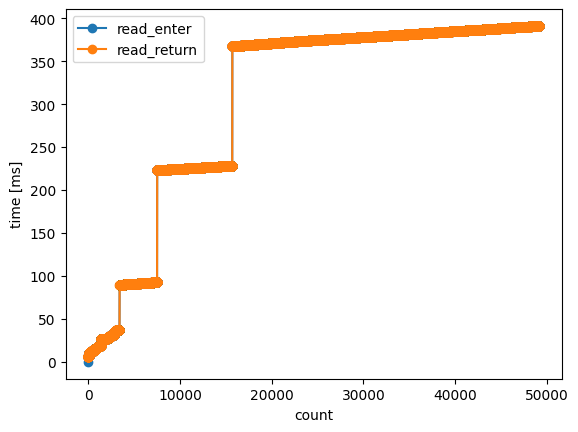

In [25]:
import read_file_vis
read_file_vis.graph(["s.dat"])

# 7. 結び
* 効果(1回目と2回目の違い)は, ディスクの性能や読み出しパターンによっても異なる
* 上記のプログラムを自分の手元にダウンロードして同じ実験をしてみることもオススメ

* 今後生きてく上で, くれぐれも, <font color="blue">キャッシュから読んだときの性能 (&gt; 数GB/sec) がディスク装置の性能である</font>と誤解しないようにしましょう
* 売られているHDD装置の性能: 1本でおおよそ100MB/sec
* 売られているSSD装置の性能: 1本でおおよそ200-300MB/sec (SATA接続) 〜 1-2GB程度 (PCI接続)
* 主記憶の性能: メモリの搭載の仕方にもよるが数十GB 〜 数百GB